### This notebook contains data preprocessing code to convert the WILDTRACK annotations to fit the format required by the JDE model
### https://github.com/Zhongdao/Towards-Realtime-MOT

### WILDTRACK dataset: https://www.epfl.ch/labs/cvlab/data/data-wildtrack/

In [28]:
import os
import json
import shutil
import random 
import math
import time
import cv2
import numpy as np

In [29]:
wt_anno_path = os.path.join('..','WILDTRACK','annotations_positions')
wt_anno_files = []
frameid = []
for jfile in os.listdir(wt_anno_path):
    frameid.append(jfile[:-5])
    wt_anno_files.append(os.path.join(wt_anno_path, jfile))
frameid[-1]

'00001995'

In [30]:
with open(wt_anno_files[0]) as f:
    js = json.load(f)
    print(js)

[{'personID': 122, 'positionID': 456826, 'views': [{'viewNum': 0, 'xmax': 1561, 'xmin': 1510, 'ymax': 299, 'ymin': 139}, {'viewNum': 1, 'xmax': 891, 'xmin': 813, 'ymax': 289, 'ymin': 10}, {'viewNum': 2, 'xmax': 1756, 'xmin': 1523, 'ymax': 1044, 'ymin': 351}, {'viewNum': 3, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}, {'viewNum': 4, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}, {'viewNum': 5, 'xmax': 676, 'xmin': 647, 'ymax': 242, 'ymin': 120}, {'viewNum': 6, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}]}, {'personID': 14, 'positionID': 448560, 'views': [{'viewNum': 0, 'xmax': 1319, 'xmin': 1273, 'ymax': 282, 'ymin': 129}, {'viewNum': 1, 'xmax': 1296, 'xmin': 1216, 'ymax': 314, 'ymin': 6}, {'viewNum': 2, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}, {'viewNum': 3, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}, {'viewNum': 4, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}, {'viewNum': 5, 'xmax': 500, 'xmin': 468, 'ymax': 250, 'ymin': 120}, {'viewNum': 6, 'xmax': 2040, 'xm

In [31]:
len(js)

38

In [32]:
js[1]

{'personID': 14,
 'positionID': 448560,
 'views': [{'viewNum': 0,
   'xmax': 1319,
   'xmin': 1273,
   'ymax': 282,
   'ymin': 129},
  {'viewNum': 1, 'xmax': 1296, 'xmin': 1216, 'ymax': 314, 'ymin': 6},
  {'viewNum': 2, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1},
  {'viewNum': 3, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1},
  {'viewNum': 4, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1},
  {'viewNum': 5, 'xmax': 500, 'xmin': 468, 'ymax': 250, 'ymin': 120},
  {'viewNum': 6, 'xmax': 2040, 'xmin': 1912, 'ymax': 339, 'ymin': 99}]}

In [33]:
js[1]['views'][0]

{'viewNum': 0, 'xmax': 1319, 'xmin': 1273, 'ymax': 282, 'ymin': 129}

In [34]:
c1 = {}
c2 = {}
c3 = {}
c4 = {}
c5 = {}
c6 = {}
c7 = {}

In [35]:
for fid in frameid:
    if not fid in c1.keys():
        c1[fid] = []
    if not fid in c2.keys():
        c2[fid] = []
    if not fid in c3.keys():
        c3[fid] = []
    if not fid in c4.keys():
        c4[fid] = []
    if not fid in c5.keys():
        c5[fid] = []
    if not fid in c6.keys():
        c6[fid] = []
    if not fid in c7.keys():
        c7[fid] = []
allCam = [c1, c2, c3, c4, c5, c6, c7]

In [36]:
def inFrame(view):
    return view['xmax'] != -1 and view['xmin'] != -1 and view['ymax'] != -1 and view['ymin'] != -1

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [37]:
%%time
img_size = [1920, 1080]
anno_dims = []
for anno, fid in zip(wt_anno_files,frameid):
    with open(anno) as f:
        annojs = json.load(f)
    for anno in annojs:
        pid = anno['personID']
        for v in anno['views']:
            if inFrame(v):
                box = [v['xmin'], v['xmax'], v['ymin'], v['ymax']]
                cbox = convert(img_size, box)
                allCam[v['viewNum']][fid].append([0, pid, cbox[0], cbox[1], cbox[2], cbox[3]])
                anno_dims.append([v['xmax']-v['xmin'], v['ymax']-v['ymin']])

Wall time: 818 ms


In [38]:
anno_dims[30000]

[97, 337]

In [39]:
def createDir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

In [40]:
%%time
annotation_dims = []
for cidx in range(len(allCam)):
    cam = allCam[cidx]
    # Create dir
    folder_name = 'C' + str(cidx+1)
    createDir(folder_name)

    for frameID in cam.keys():
        file_name = frameID + '.txt'
        np.savetxt(os.path.join(folder_name, file_name), cam[frameID], fmt='%s')
        for line in cam[frameID]:
            annotation_dims.append([line[4], line[5]])

Wall time: 5.21 s


In [41]:
test_img = cv2.imread('00000000.png')
boxes = allCam[0]['00000000']
# for box in boxes:
#     x, y = box[2] * 1920, box[3] * 1080
#     w, h = box[4] * 1920, box[5] * 1080
#     cv2.rectangle(test_img, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 0, 255), 2)
cv2.rectangle(test_img, (1510, 139), (1561, 299), (0,0,255),2)
cv2.rectangle(test_img, (1273, 129), (1319, 282), (0,0,255),2)

array([[[ 39,  43,  43],
        [ 52,  57,  57],
        [ 60,  64,  64],
        ...,
        [123, 164, 169],
        [138, 179, 184],
        [157, 199, 203]],

       [[ 40,  46,  46],
        [ 46,  52,  52],
        [ 49,  55,  55],
        ...,
        [125, 168, 172],
        [148, 191, 195],
        [168, 211, 215]],

       [[ 45,  52,  52],
        [ 47,  53,  53],
        [ 48,  54,  54],
        ...,
        [155, 198, 202],
        [171, 214, 218],
        [180, 223, 227]],

       ...,

       [[123, 137, 136],
        [122, 136, 135],
        [117, 131, 130],
        ...,
        [ 88,  88,  86],
        [ 89,  89,  87],
        [ 90,  90,  88]],

       [[114, 128, 127],
        [116, 130, 128],
        [117, 131, 129],
        ...,
        [ 88,  88,  86],
        [ 89,  89,  87],
        [ 89,  89,  87]],

       [[113, 127, 124],
        [115, 129, 126],
        [116, 130, 127],
        ...,
        [ 89,  89,  87],
        [ 89,  89,  87],
        [ 89,  89,  87]]

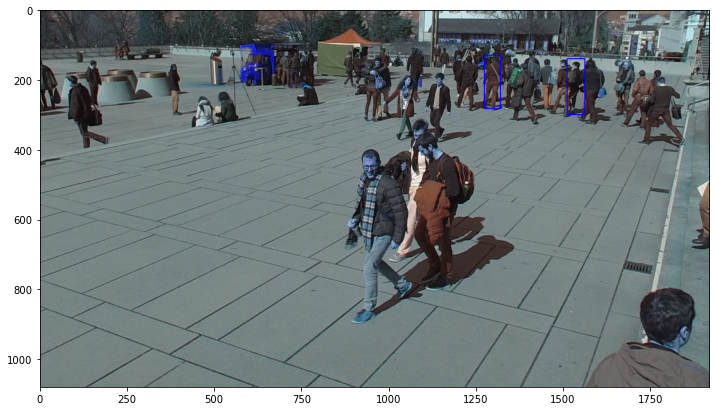

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(test_img)

## Generate anchors

In [43]:
class YOLO_Kmeans:

    def __init__(self, cluster_number, filename):
        self.cluster_number = cluster_number
        self.filename = filename

    def iou(self, boxes, clusters):  # 1 box -> k clusters
        n = boxes.shape[0]
        k = self.cluster_number

        box_area = boxes[:, 0] * boxes[:, 1]
        box_area = box_area.repeat(k)
        box_area = np.reshape(box_area, (n, k))

        cluster_area = clusters[:, 0] * clusters[:, 1]
        cluster_area = np.tile(cluster_area, [1, n])
        cluster_area = np.reshape(cluster_area, (n, k))

        box_w_matrix = np.reshape(boxes[:, 0].repeat(k), (n, k))
        cluster_w_matrix = np.reshape(np.tile(clusters[:, 0], (1, n)), (n, k))
        min_w_matrix = np.minimum(cluster_w_matrix, box_w_matrix)

        box_h_matrix = np.reshape(boxes[:, 1].repeat(k), (n, k))
        cluster_h_matrix = np.reshape(np.tile(clusters[:, 1], (1, n)), (n, k))
        min_h_matrix = np.minimum(cluster_h_matrix, box_h_matrix)
        inter_area = np.multiply(min_w_matrix, min_h_matrix)

        result = inter_area / (box_area + cluster_area - inter_area)
        return result

    def avg_iou(self, boxes, clusters):
        accuracy = np.mean([np.max(self.iou(boxes, clusters), axis=1)])
        return accuracy

    def kmeans(self, boxes, k, dist=np.median):
        box_number = boxes.shape[0]
        distances = np.empty((box_number, k))
        last_nearest = np.zeros((box_number,))
        np.random.seed()
        clusters = boxes[np.random.choice(
            box_number, k, replace=False)]  # init k clusters
        while True:

            distances = 1 - self.iou(boxes, clusters)

            current_nearest = np.argmin(distances, axis=1)
            if (last_nearest == current_nearest).all():
                break  # clusters won't change
            for cluster in range(k):
                clusters[cluster] = dist(  # update clusters
                    boxes[current_nearest == cluster], axis=0)

            last_nearest = current_nearest

        return clusters

    def result2txt(self, data):
        f = open("yolo_anchors.txt", 'w')
        row = np.shape(data)[0]
        for i in range(row):
            if i == 0:
                x_y = "%d,%d" % (data[i][0], data[i][1])
            else:
                x_y = ", %d,%d" % (data[i][0], data[i][1])
            f.write(x_y)
        f.close()

    def txt2boxes(self):
        f = open(self.filename, 'r')
        dataSet = []
        for line in f:
            infos = line.split(" ")
            length = len(infos)
            for i in range(1, length):
                width = int(infos[i].split(",")[2]) - \
                    int(infos[i].split(",")[0])
                height = int(infos[i].split(",")[3]) - \
                    int(infos[i].split(",")[1])
                dataSet.append([width, height])
        result = np.array(dataSet)
        f.close()
        return result

    def txt2clusters(self, boxes):
        # all_boxes = self.txt2boxes()
        all_boxes = boxes
        result = self.kmeans(all_boxes, k=self.cluster_number)
        result = result[np.lexsort(result.T[0, None])]
        self.result2txt(result)
        print("K anchors:\n {}".format(result))
        print("Accuracy: {:.2f}%".format(
            self.avg_iou(all_boxes, result) * 100))

In [44]:
annotation_dims = np.array(anno_dims)

In [45]:
%%time
filename = 'wt_anchor.txt'
kmeans = YOLO_Kmeans(12, file_name)
kmeans.txt2clusters(annotation_dims)

K anchors:
 [[ 27 108]
 [ 33 123]
 [ 40 143]
 [ 46 187]
 [ 49 163]
 [ 57 196]
 [ 66 222]
 [ 75 262]
 [ 91 322]
 [124 368]
 [172 538]
 [273 773]]
Accuracy: 86.91%
Wall time: 1.14 s


# Generate manifest

In [46]:
out_content = []
folders = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
for fold in folders:
    files = os.listdir(fold)
    path = '/diskd/raymond/WILDTRACK/images/'
    for f in files:
        out_files = f.replace('.txt', '.png')
        out_content.append(path+fold+'/'+out_files)

In [47]:
out_content[:5]

['/diskd/raymond/WILDTRACK/images/C1/00000000.png',
 '/diskd/raymond/WILDTRACK/images/C1/00000005.png',
 '/diskd/raymond/WILDTRACK/images/C1/00000010.png',
 '/diskd/raymond/WILDTRACK/images/C1/00000015.png',
 '/diskd/raymond/WILDTRACK/images/C1/00000020.png']

In [48]:
np.savetxt('wildtrack_train.train', out_content, fmt='%s')